## Imports 

In [1]:
from ast import literal_eval
from collections import Counter

import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd 
import numpy as np 
import torch
import torch.nn as nn 

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

In [2]:
torch.manual_seed(0) # reproducibility не будет, однако. здесь ошибся немного

In [3]:
df = pd.read_csv("../jigsaw-toxic-comment-classification-challenge/train.csv")

## RNNs

Please, read about RNNs (Recurrent Neural Networks).  

1. Understand it's difference from the FFNNs. (Write your answer down below)  

https://towardsdatascience.com/recurrent-neural-networks-rnn-explained-the-eli5-way-3956887e8b75

https://towardsdatascience.com/learn-how-recurrent-neural-networks-work-84e975feaaf7

2. Why do we need recurrent neural networks? 
3. For which tasks it would work better? 

1. Основным свойством рекуррентных нейронных сетей, которая отличает их от сетей прямой связи, это применение результатов выходного слоя сети в качестве входных данных для повторных вычислений. 
2. В RNN-подобных сетях есть некая реализация памяти, чего нет в классических FFNN сетях.
3. Благодаря своим свойствам и структуре, рекуррентная нейронная сеть - как один из хороших подходов к решению некоторых основных задач естественной обработки текста. В качестве примера можно взять семантический анализ текста. Или же анализ частей речи слов в предложениях - здесь проще применить RNN, чем FFNN.

## Load data 

In [4]:
# Load the DF created during the previous task

df_binary = pd.read_csv("../jigsaw-toxic-comment-classification-challenge/df_binary.csv")
df_binary.head()

,Unnamed: 0,index,Unnamed: 0.1,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,cleaned,toxicity
0,0,99113,110315,4e2c098f06673358,REDIRECT Talk:Worcester cold storage and wareh...,0,0,0,0,0,0,"['redirect', 'talk', 'worcester', 'cold', 'sto...",0
1,1,82092,91416,f470fbfb8a45a534,No they shouldn't. Sublime is a ska band not ...,0,0,0,0,0,0,"[""n't"", 'sublime', 'ska', 'band', 'surf', 'band']",0
2,2,59810,66609,b2403a014d32fd1e,"""]] comment added by (talk • contribs) \n\nI'...",0,0,0,0,0,0,"['``', 'comment', 'added', 'talk', '•', 'contr...",0
3,3,91316,101618,1fd66f99a02f5165,"Apologies, I have had some trouble with people...",0,0,0,0,0,0,"['apology', 'trouble', 'people', 'hacking', 'a...",0
4,4,13332,14837,2738689dc32d05c6,"While you opinion is valuable, it loses its va...",0,0,0,0,0,0,"['opinion', 'valuable', 'loses', 'value', 'use...",0


In [5]:
# Work with small amount of this data: 
df_sample, _ = train_test_split(df_binary, test_size=0.7, stratify=df_binary['obscene'])

In [6]:
def flat_nested(nested):
    flatten = []
    for item in nested:
        if isinstance(item, list):
            flatten.extend(item)
        else:
            flatten.append(item)
    return flatten

cnt_vocab = Counter(flat_nested(df_sample.cleaned.apply(literal_eval).tolist())) # <<<<

print("Vocab size before filtering: {}".format(len(cnt_vocab)))

threshold_count_l = 1
threshold_count_h = 500
threshold_len = 2

cleaned_vocab = [token for token, count in cnt_vocab.items() if 
                     threshold_count_h > count > threshold_count_l and len(token) > threshold_len
                ]
print("Vocab size after filtering: {}".format(len(cleaned_vocab)))

Vocab size before filtering: 107336
Vocab size after filtering: 41973


In [7]:
cleaned_vocab.append(" ")
# Convert list to set 
cleaned_vocab = set(cleaned_vocab)

In [8]:
token_to_id = {v: k for k, v in enumerate(sorted(cleaned_vocab))}
id_to_token = {v: k for k, v in token_to_id.items()}

Before passing our raw text to the model we need to represent each raw text by a vector.   
Let's do this by creating an empty list with all of the tokens in it represented by its id. 

In [9]:
def vectorize(data, token_to_id, max_len=None, dtype='int32', batch_first=True):
    """
    Casts a list of tokens into rnn-digestable matrix
        "data" contains only sequences represented by tokens from the dictionary, filter noise before 
    """
    seq_lengths = list(map(len, data))
    max_len = max_len or max(map(len, data))
    # Create a marix with a shape [batch size, max number of tokens in sequence]
    data_ix = np.zeros([len(data), max_len], dtype) + token_to_id[' ']

    for i in range(len(data)):
        line_ix = [token_to_id[c] for c in data[i]]
        data_ix[i, :len(line_ix)] = line_ix

    return data_ix, seq_lengths

In [10]:
def filter_noise_tokens(df, cleaned_vocab): 
    df['filtered_tokens'] = df.cleaned.apply(lambda x: [tok for tok in x if tok in cleaned_vocab])
    return df 

In [11]:
# After applying this function there would be sentences with all tokens filtered - empty lists. 
df_sample.cleaned = df_sample.cleaned.apply(literal_eval)
df_sample = filter_noise_tokens(df_sample, cleaned_vocab)

# Remove examples without any tokens assigned 
df_filtered = df_sample[df_sample.astype(str)['filtered_tokens'] != '[]']

c:\users\laplace-transform\appdata\local\programs\python\python37\lib\site-packages\pandas\core\generic.py:5208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
c:\users\laplace-transform\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [12]:
df_filtered

,Unnamed: 0,index,Unnamed: 0.1,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,cleaned,toxicity,filtered_tokens
85866,85866,105903,117833,7575cc49b960a3b5,I have a ghost I.P. Address. It changes ewvery...,0,0,0,0,0,0,"[ghost, i.p, address, change, ewvery, time, si...",0,"[ghost, i.p, internet, worst]"
23953,23953,92145,102563,24e717f414c4713e,Gaijin42 inserted fake statistics into the Def...,0,0,0,0,0,0,"[gaijin42, inserted, fake, statistic, defensiv...",0,"[gaijin42, inserted, fake, statistic, defensiv..."
136227,136227,16863,18806,31a0dbce1c035262,Please stop. If you continue to vandalize page...,0,0,0,0,0,0,"[please, stop, continue, vandalize, page, bloc...",0,[contribs/talk]
146041,146041,14587,16226,2ac77b98a6527cd6,How do you see my edits so quickly,0,0,0,0,0,0,"[see, edits, quickly]",0,[quickly]
119397,119397,26913,30039,4fc3ed5a2c5d2e89,Can someone delete my account or tell me how t...,0,0,0,0,0,0,"[someone, delete, account, tell, please, thank...",0,[thankful]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11984,11984,3949,4422,0bc1de1601fb8b91,You really need a life dude.,0,0,0,0,0,0,"[really, need, life, dude]",0,[dude]
7013,7013,115096,128100,ad1fff21218dd5b0,"""\n\nPlease do not add nonsense to Wikipedia. ...",0,0,0,0,0,0,"[``, please, add, nonsense, wikipedia, conside...",0,"[nonsense, experiment]"
146838,146838,63096,70268,bbfd162cbe4282ed,"""\nNBeale spends so much time crying foul over...",0,0,0,0,0,0,"[``, nbeale, spends, much, time, cry, foul, no...",0,"[spends, cry, foul, nonexistent, calling, fell..."
96062,96062,62500,69610,ba339051462aae4b,"Feel free to change it. Who knows, maybe this ...",0,0,0,0,0,0,"[feel, free, change, know, maybe, company, emp...",0,[employee]


In [13]:
# Perform train-test split stratified (would be imbalanced)
df_train, df_test = train_test_split(df_filtered, test_size=0.4, stratify=df_filtered['obscene'])

In [14]:
print("Train shape: {}".format(df_train.shape))
print("Test shape: {}".format(df_test.shape))

Train shape: (26416, 14)
Test shape: (17612, 14)


In [15]:
class RNNLoop(nn.Module):
    
    def __init__(self, num_tokens, emb_size=200, hid_size=128):
        super(self.__class__, self).__init__()
        self.emb = nn.Embedding(num_tokens, emb_size)
        self.rnn = nn.RNN(emb_size, hid_size, batch_first=True)
        self.logits = nn.Linear(hid_size, 1)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x, seq_lengths):
        # Embed the obtained sequence 
        emb = self.emb(x)
        # Pack padded sequence - why do we need this, refer to:
        # https://stackoverflow.com/questions/51030782/why-do-we-pack-the-sequences-in-pytorch
        
        pack = torch.nn.utils.rnn.pack_padded_sequence(emb,
                                                   seq_lengths,
                                                   batch_first=True,
                                                   enforce_sorted=False
                                                  ) 
        all_hidden_states, hidden = self.rnn(pack)
        logits = self.logits(hidden)
        # Cast logits to the range from 0 to 1 
        output = self.sigmoid(logits)
        return output

In [16]:
loss_unbalanced = []
loss_stratified = []
loss_upscaled = []

In [17]:
def fast_train_loss_plot(Y, axs = None):
    X = range(1, len(Y)+1)
    sns.lineplot(
        x = "epochs", y = "loss", 
        data = pd.DataFrame(np.vstack((X, Y)).T, columns=["epochs", "loss"]), ax = axs
    )

In [18]:
# Initialise the model 
model = RNNLoop(num_tokens=len(cleaned_vocab))
# specify loss function
criterion = nn.BCELoss()
# specify optimizer
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0075)
#history = []

batch_size = 64
n_epochs = 10
n_iters = df_train.shape[0] // batch_size
print("Number of iterations for 1 epoch: {}".format(n_iters))

for epoch in range(n_epochs):
    epoch_loss = 0 
    for step in range(n_iters):

        optimizer.zero_grad()    # Forward pass
        # Make a random sample from the dataframe 
        sample = df_train.sample(batch_size)

        # Vectorize the obtained sample 
        batch_ix, seq_lengths = vectorize(sample.filtered_tokens.tolist(), token_to_id)
        # Convert vectorized batch to tensor 
        batch_ix = torch.tensor(batch_ix, dtype=torch.int64)

        # Select true labels 
        y_true = sample.obscene.tolist()
        # Convert true labels to tensor 
        y_true = torch.tensor(y_true, dtype=torch.float)

        # Make prediction 
        y_pred = model(batch_ix, seq_lengths)

        loss = criterion(y_pred.squeeze(), y_true)

        epoch_loss += loss.item() / n_iters
        loss.backward()   # Backward pass 
        optimizer.step()
        
    loss_unbalanced.append(epoch_loss)
            
    print('Epoch {}: train loss: {}'.format(epoch, epoch_loss))    

Number of iterations for 1 epoch: 412
Epoch 0: train loss: 0.17049564060402406
Epoch 1: train loss: 0.09501083108971749
Epoch 2: train loss: 0.059688882277803786
Epoch 3: train loss: 0.04069835199743911
Epoch 4: train loss: 0.02972399986626523
Epoch 5: train loss: 0.02411615812380459
Epoch 6: train loss: 0.015680568537223313
Epoch 7: train loss: 0.013316547586707637
Epoch 8: train loss: 0.012182853116772682
Epoch 9: train loss: 0.03375385335564415


In [19]:
# Functions for test dataset splitting on batches 

def index_marks(nrows, chunk_size):
    return range(1 * chunk_size, (nrows // chunk_size + 1) * chunk_size, chunk_size)

def split(df, chunk_size):
    indices = index_marks(df.shape[0], chunk_size)
    return np.split(df, indices)

In [20]:
def make_predictions(model, df_test, batch_size, threshold): 
    n_prints = 0
    predictions = []
    true_labels = []
    # Split data in batches 
    test_batches = split(df_test, batch_size)
    
    for batch in test_batches:
        # Vectorize batches
        batch_ix, seq_lengths = vectorize(batch.filtered_tokens.tolist(), token_to_id)
        # Convert vectorized batch to tensor 
        batch_ix = torch.tensor(batch_ix, dtype=torch.int64)

        # Select true labels 
        y_true = batch.obscene.tolist()

        # Make prediction 
        y_pred = model(batch_ix, seq_lengths).detach().squeeze().numpy()
        # Convert it to binaries 
        y_pred = [int(pred.item() > threshold) for pred in y_pred]
        
        # Add them to parallel lists 
        predictions.extend(y_pred)
        true_labels.extend(y_true)
        
        # Print some examples with obscene documents texts and predicted and true labels 
        for true, pred, document in zip(y_true, y_pred, batch.comment_text):
            if true == 1.0 and n_prints < 10:
                print("Predicted label: {}".format(pred))
                print("True label: {}".format(true))
                print("Document: {}".format(document))
                print("*-*-"*20)
                n_prints += 1
        
    return true_labels, predictions

In [21]:
true_labels, predictions = make_predictions(model, df_test, batch_size=64, threshold=0.3)

Predicted label: 1
True label: 1
Document: And you are a jackass for doing so.  The same disclaimer is on EVERY HIV antibody kit with very little variation.
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
Predicted label: 1
True label: 1
Document: Hey bitch! guess what 

Koschecks fighting at ufc 82... you know waht that means...so give your adress so i could make u suck my cock
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
Predicted label: 0
True label: 1
Document: Hi Pete 

You're a prick!

Yours sincerely, someone who would never dream of buying such a rag as the MoS.
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
Predicted label: 1
True label: 1
Document: MUSLIM SCUM go die soon will you
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
Predicted label: 1
True label: 1
Document: There's a cock in your ass.
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*

In [22]:
# Pring a classification report: 
print(classification_report(true_labels, predictions))
print(accuracy_score(true_labels, predictions))

              precision    recall  f1-score   support

           0       0.97      0.93      0.95     16655
           1       0.28      0.47      0.35       957

    accuracy                           0.91     17612
   macro avg       0.62      0.70      0.65     17612
weighted avg       0.93      0.91      0.92     17612

0.9050647285941403


In [23]:
# let's try to implement poor stratifying
def stratified_train_test(frame, name_col, train_size = 0.5, reset_idx = False):
    
    assert 0 < train_size < 1
    
    frame_train_non = frame[frame['toxicity'] == 0].sample(int(train_size * len(frame[frame['toxicity'] == 0])))
    frame_train_mrk = frame[frame[name_col] != 0].sample(int(train_size * len(frame[frame[name_col] != 0])))
    
    frame_train = frame_train_non.append(frame_train_mrk).sample(frac = 1)
    frame_test = frame.drop(index = frame_train.index).sample(frac = 1)
    
    if reset_idx:
        frame_train = frame_train.reset_index(drop = True)
        frame_test = frame_test.reset_index(drop = True)
        
    return frame_train, frame_test

In [24]:
df_train, df_test = stratified_train_test(df_filtered, 'obscene', 0.6)

In [25]:
model = RNNLoop(num_tokens=len(cleaned_vocab))
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0075)

batch_size = 64
n_epochs = 10
n_iters = df_train.shape[0] // batch_size
print("Number of iterations for 1 epoch: {}".format(n_iters))

for epoch in range(n_epochs):
    epoch_loss = 0 
    for step in range(n_iters):

        optimizer.zero_grad()
        sample = df_train.sample(batch_size)

        batch_ix, seq_lengths = vectorize(sample.filtered_tokens.tolist(), token_to_id)
        batch_ix = torch.tensor(batch_ix, dtype=torch.int64)

        y_true = sample.obscene.tolist()
        y_true = torch.tensor(y_true, dtype=torch.float)
        y_pred = model(batch_ix, seq_lengths)

        loss = criterion(y_pred.squeeze(), y_true)
        epoch_loss += loss.item() / n_iters
        
        loss.backward()
        optimizer.step()
                
    loss_stratified.append(epoch_loss)
                
    print('Epoch {}: train loss: {}'.format(epoch, epoch_loss))    

Number of iterations for 1 epoch: 412
Epoch 0: train loss: 0.17626454129598107
Epoch 1: train loss: 0.09316144630796674
Epoch 2: train loss: 0.060275936628086044
Epoch 3: train loss: 0.04203050076996563
Epoch 4: train loss: 0.03725895003737198
Epoch 5: train loss: 0.029148891946604354
Epoch 6: train loss: 0.02427543132802986
Epoch 7: train loss: 0.019189974883948746
Epoch 8: train loss: 0.0156862732108193
Epoch 9: train loss: 0.018038833788682283


In [26]:
true_labels, predictions = make_predictions(model, df_test, batch_size=64, threshold=0.3)
print(classification_report(true_labels, predictions))
print(accuracy_score(true_labels, predictions))

Predicted label: 0
True label: 1
Document: But where is the evidence??? iam really not a sock puppet and how have i been harassing people? really other people have been harassing me like styrofoam1994 who called me a dick head. Is that not a harassment? and truly if i ment to hurt anyone's feelings i didn't mean it but i doubt i did
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
Predicted label: 0
True label: 1
Document: Why are you STILL harassing me?  Do you love Boston that much?  Where the fuck(that is right, I wrote it.) is you threat or block of that clown who left racists comments over a BS topic?  Was it you?  You have a serious problem.  Why in the hell are you following me every place I go on here.  The Indian thing was a fucking comment that anyone can leave.  If you search on this whole site, you wil find FAR worse than what I wrote.  You faggots (yeah I wrote that too.  I guess you can see that I can give a fuck about a block since I can c

Применение районированной выборки для обучения и валидации модели приносит результаты немного лучше. Но ситуация с небольшим количеством текстов с пометкой 'obscene' всё ещё остаётся нерешённой. Необходимо как-то манипулировать данными, чтобы увеличить объём проблематичного подмножества выборки.

In [27]:
# now we'll be using upscaling method

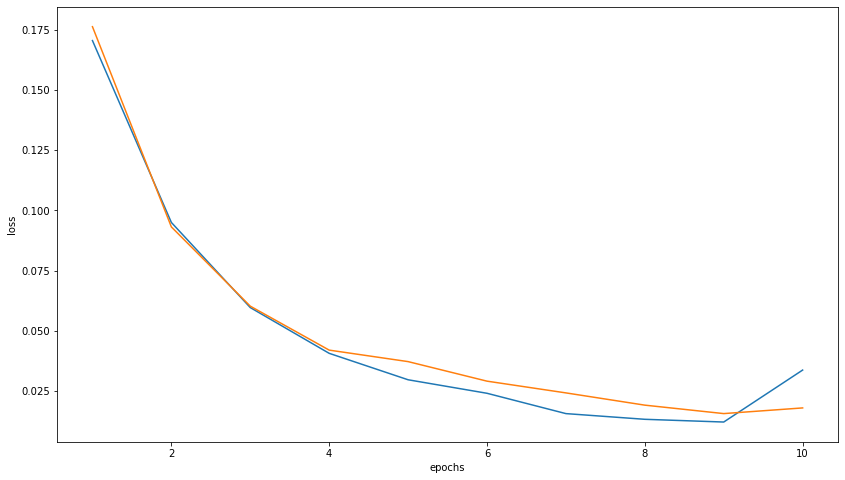

In [28]:
f, a = plt.subplots(1, 1, figsize = (14, 8))

fast_train_loss_plot(loss_unbalanced, a) # blue
fast_train_loss_plot(loss_stratified, a) # orange

## Task

1. Make a dataset balanced: for example select all of the obscene messages, calculate its number and sample from the clean 
messages equal number of examples. **(1)See if it increased your score on toxic messages.** 

As the **additional** task you can modify your dataset sampling during the training/testing. Read about Datasets, DataSamplers and DataLoaders in pytorch. Try to apply them. 


2. Read about RNNs different types (LSTMs and GRUs): 
  https://colah.github.io/posts/2015-08-Understanding-LSTMs/  

  https://towardsdatascience.com/illustrated-guide-to-lstms-and-gru-s-a-step-by-step-explanation-44e9eb85bf21 
  
  **(2)What is the difference between RNN and LSTM? Why do we need LSTM? Explain it in your own words.**  
  
  **(3)What is the difference between LSTM and GRU? Explain it in your own words.** 
  
  
3. Modify your network to make it possible to work with nn.LSTM or nn.GRU layers. (Their outputs may be a little bit defferent from nn.RNN, so be careful to modify your code accordingly). 

4. Compare all of the previous examples: classification with RNN (or LSTM/GRU) and FFNN. **(4)Which one performed better according to the metrics? (5)To the time?**

5. **(6)How dataset imbalancing are influencing your model? Read about dataset imbalancing and about possibilities to handle them. (7)Write down below what can we do with it, or implement a solution.** 
  
  

Please, answer the questions 1-7 and write your answers down below: 

(Здесь ещё не дописал)
1. Ответ дан немного раньше. Если кратко - помогло. Но этого недостаточно, можно большего добиться.
2. RNN vs LSTM
3. LSTM vs GRU
4. RNN vs FFNN - metrics
5. Исходя из проделанного в этой блокноте, хочется утверждать, что модель RNN учится дольше модели FFNN. Это объясняется сложностью первой структуры...  
6. Интуитивно ясно, что существует прямая зависимость между качеством собранных данных для модели и её итоговыми показателями...
7. Проблему о слабо сбалансированном наборе данных для модели можно решить двумя основными способами. Первым способом будет создание районированной выборки из исходной, вторым - искусственный метод увеличения объёма малого подмножества выборки (по сравнению с количеством остальных данных в ней).